In [1]:
import pandas as pd
import numpy as np
from vowpalwabbit import pyvw
import matplotlib.pyplot as plt
import math
import slates

def setup_outcomes():
    return {('Mac', 'wifi', 'CA'): [], ('Mac', 'wifi', 'US'): [], ('Mac', 'wired', 'CA'): [], ('Mac', 'wired', 'US'): [], ('Windows', 'wifi', 'CA'): [], ('Windows', 'wifi', 'US'): [], ('Windows', 'wired', 'CA'): [], ('Windows', 'wired', 'US'): []}

In [2]:
GROUND_TRUTH_DATASET = "data/df_all_4_3_2_100runs.csv"
TEST_DATASETS = {
#     "20_15_10" : "data/gen/df_all_20_15_10_5runs.csv",
#     "20_15_10" : "data/df_all_20_15_10_5runs.csv"
    "4_3_2" : "data/df_all_4_3_2_50runs.csv"
}

In [3]:
test_configs = {}
for name in TEST_DATASETS:
    test_configs[name] = {}
    df = pd.read_csv(TEST_DATASETS[name])
    test_configs[name]["data"] = df
    test_configs[name]["rewards"] = pd.DataFrame(df.groupby(['platform', 'network', 'country','x','y','z'])['reward'].unique()).reset_index()
    test_configs[name]["x"] = sorted(df["x"].unique())
    test_configs[name]["y"] = sorted(df["y"].unique())
    test_configs[name]["z"] = sorted(df["z"].unique())
    test_configs[name]["x_actions"] = ["x="+str(a) for a in test_configs[name]["x"]]
    test_configs[name]["y_actions"] = ["y="+str(a) for a in test_configs[name]["y"]]
    test_configs[name]["z_actions"] = ["z="+str(a) for a in test_configs[name]["z"]]
    
    all_string_actions, all_actions = slates.combine_float_actions(test_configs[name]["x"],test_configs[name]["y"],test_configs[name]["z"])
    test_configs[name]["all_string_actions"] = all_string_actions
    test_configs[name]["all_actions"] = all_actions


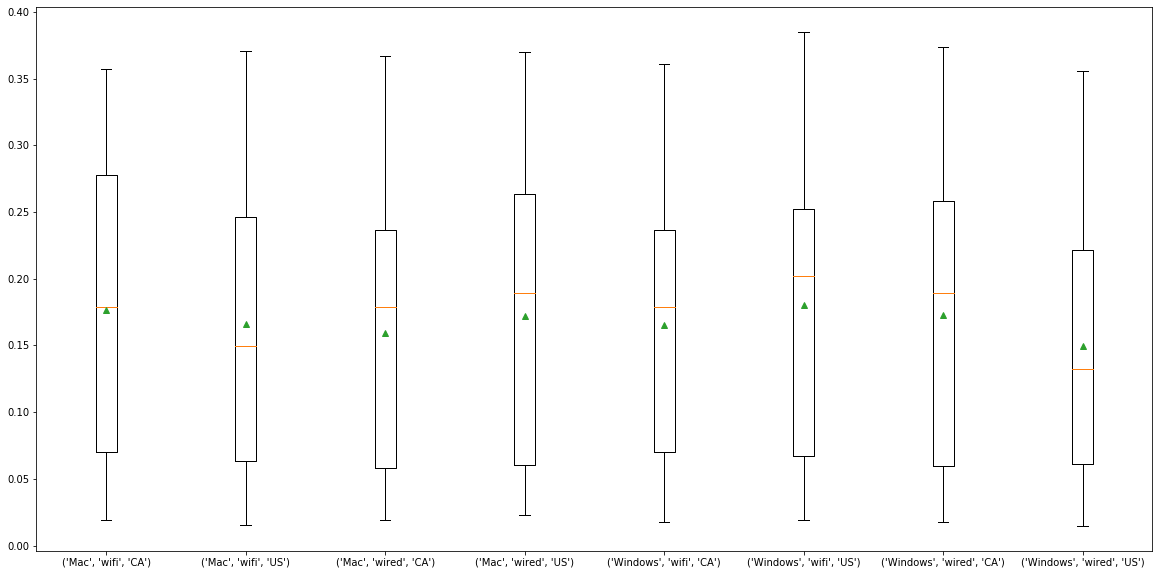

In [4]:
ground_truth_df = pd.read_csv(GROUND_TRUTH_DATASET)
ground_truth_rewards_df = pd.DataFrame(ground_truth_df.groupby(['platform', 'network', 'country','x','y','z'])['reward'].unique()).reset_index()

min_reward = {}
min_actions = {}

plt.figure(figsize=(20, 10))

grps_context = ground_truth_df.groupby(['platform', 'network', 'country'])
for i, context in enumerate(grps_context.groups.keys()):
    df_temp = grps_context.get_group(context)
    if context not in min_reward.keys():
        min_reward[context] = {}
    grps_action = df_temp.groupby(['x', 'y', 'z'])
    for action in grps_action.groups.keys():
        df_temp2 = grps_action.get_group(action)
        min_reward[context][action] = np.mean(df_temp2['reward'])
        
    min_reward_action = min(min_reward[context], key=min_reward[context].get)
    min_actions[context] = min_reward_action
    plt.boxplot(grps_action.get_group(min_reward_action)["reward"], positions=[i], labels=["{}".format(context)], showmeans=True)

plt.show()


In [33]:
def optimal_policy_sample(context, action):
    row_index = ground_truth_rewards_df.index[(ground_truth_rewards_df['platform'] == context[0])
                                           & (ground_truth_rewards_df['network'] == context[1])
                                           & (ground_truth_rewards_df['country'] == context[2])
                                           & (ground_truth_rewards_df['x'] == action[0])
                                           & (ground_truth_rewards_df['y'] == action[1])
                                           & (ground_truth_rewards_df['z'] == action[2])
                                          ]
    possible_rewards = ground_truth_rewards_df.iloc[row_index[0]]["reward"]
    return np.random.choice(possible_rewards)

def optimal_policy_median(context, action):
    row_index = ground_truth_rewards_df.index[(ground_truth_rewards_df['platform'] == context[0])
                                           & (ground_truth_rewards_df['network'] == context[1])
                                           & (ground_truth_rewards_df['country'] == context[2])
                                           & (ground_truth_rewards_df['x'] == action[0])
                                           & (ground_truth_rewards_df['y'] == action[1])
                                           & (ground_truth_rewards_df['z'] == action[2])
                                          ]
    possible_rewards = ground_truth_rewards_df.iloc[row_index[0]]["reward"]
    return np.median(possible_rewards)


# Slates

In [34]:
for name in test_configs:
    test_configs[name]["outcomes"] = setup_outcomes()
    test_configs[name]["x_outcomes"] = setup_outcomes()
    test_configs[name]["y_outcomes"] = setup_outcomes()
    test_configs[name]["z_outcomes"] = setup_outcomes()
    
    model = pyvw.vw("--ccb_explore_adf --cb_type ips --power_t 0 -l 0.005 --slate --quiet --epsilon 0.2 -q :: --interactions UUU AAA UUA AAU UUUA UUUAA UUUAAA")

    df = test_configs[name]["data"]
    rewards = test_configs[name]["rewards"]

    for _ in range(10000):
        choice = np.random.choice(len(df))
        current_row = df.iloc[choice]
        platform = current_row["platform"]
        country = current_row["country"]
        network = current_row["network"]

        shared_context = "platform={} region={} connection={}".format(platform, country, network)
        examples = slates.create_slates_example(model, shared_context, [test_configs[name]["x_actions"], test_configs[name]["y_actions"], test_configs[name]["z_actions"]])
        pred = slates.slate_pred_conv(model.predict(examples, prediction_type=pyvw.pylibvw.vw.pDECISION_SCORES))
        model.finish_example(examples)
        
        # Choose the slot to samlpe
        chosen_slot = np.random.choice(len(pred))
        slot_to_sample = pred[chosen_slot]
        # Sample an index from this slot
        index = slates.sample_index(slot_to_sample)
        # Swap sampled action if it was not the 0th item.
        if index != 0:
            slot_to_sample[0], slot_to_sample[index] = slot_to_sample[index], slot_to_sample[0]
        # Assign the potentially modified slot back into the prediction
        pred[chosen_slot] = slot_to_sample
        
        exploit_a = 0
        for pred_a in pred:
            all_probs = [x[1] for x in pred_a]
            if pred_a[0][0] == max(pred_a,key=lambda x:x[1])[0] and not(all_probs[1:] == all_probs[:-1]):
                exploit_a +=1

        chosen_x = test_configs[name]["x"][pred[0][0][0]]
        chosen_y = test_configs[name]["y"][pred[1][0][0]]
        chosen_z = test_configs[name]["z"][pred[2][0][0]]
               
        row_index = rewards.index[(rewards['platform'] == platform)
                                       & (rewards['network'] == network)
                                       & (rewards['country'] == country)
                                       & (rewards['x'] == chosen_x)
                                       & (rewards['y'] == chosen_y)
                                       & (rewards['z'] == chosen_z)
                                      ]
        # Choose a reward from the set that matched this example
        possible_rewards = rewards.iloc[row_index[0]]["reward"]
        cost = np.random.choice(possible_rewards)
        test_configs[name]["outcomes"][(platform,network,country)].append(cost)

        x_index = test_configs[name]["x_actions"].index("x="+str(chosen_x))
        y_index = test_configs[name]["y_actions"].index("y="+str(chosen_y))
        z_index = test_configs[name]["z_actions"].index("z="+str(chosen_z))
        x_outcome = (x_index, cost, pred[0][0][1])
        y_outcome = (y_index, cost, pred[1][0][1])
        z_outcome = (z_index, cost, pred[2][0][1])
        
        # Only save the outcome for plotting if it was exploit
        if exploit_a == 3:
            test_configs[name]["x_outcomes"][(platform,network,country)].append(test_configs[name]["x"][x_index])
            test_configs[name]["y_outcomes"][(platform,network,country)].append(test_configs[name]["y"][y_index])
            test_configs[name]["z_outcomes"][(platform,network,country)].append(test_configs[name]["z"][z_index])

        examples = slates.create_slates_example(model, shared_context, [test_configs[name]["x_actions"], test_configs[name]["y_actions"], test_configs[name]["z_actions"]], [x_outcome,y_outcome,z_outcome])
        model.learn(examples)
        model.finish_example(examples)

# Combinatorial CB

In [35]:
for name in test_configs:
    test_configs[name]["cb_outcomes"] = setup_outcomes()
    test_configs[name]["cb_x_outcomes"] = setup_outcomes()
    test_configs[name]["cb_y_outcomes"] = setup_outcomes()
    test_configs[name]["cb_z_outcomes"] = setup_outcomes()
    
    cb_model = pyvw.vw("--cb_explore_adf --cb_type ips --power_t 0 -l 0.005 --quiet --epsilon 0.2 -q :: --interactions UUU AAA UUA AAU UUUA UUUAA UUUAAA")


    df = test_configs[name]["data"]
    rewards = test_configs[name]["rewards"]
    for _ in range(10000):
        choice = np.random.choice(len(df))
        current_row = df.iloc[choice]
        platform = current_row["platform"]
        country = current_row["country"]
        network = current_row["network"]

        shared_context = "platform={} region={} connection={}".format(platform, country, network)
        examples = slates.create_cb_example(cb_model, shared_context, test_configs[name]["all_string_actions"])
        pred = cb_model.predict(examples, prediction_type=pyvw.pylibvw.vw.pACTION_SCORES)
        cb_model.finish_example(examples)

        # Sample
        chosen_action_index = np.random.choice(len(pred), p=slates.normalize(pred))
        chosen_action = test_configs[name]["all_actions"][chosen_action_index]
        chosen_pred = pred[chosen_action_index]

        row_index = rewards.index[(rewards['platform'] == platform)
                                       & (rewards['network'] == network)
                                       & (rewards['country'] == country)
                                       & (rewards['x'] == chosen_action[0])
                                       & (rewards['y'] == chosen_action[1])
                                       & (rewards['z'] == chosen_action[2])
                                      ]

        # Choose a reward from the set that matched this example
        possible_rewards = rewards.iloc[row_index[0]]["reward"]
        cost = np.random.choice(possible_rewards)
        test_configs[name]["cb_outcomes"][(platform,network,country)].append(cost)
        
        # Only save the outcome for plotting if it was exploit
        if chosen_action_index == 0:
            test_configs[name]["cb_x_outcomes"][(platform,network,country)].append(chosen_action[0])
            test_configs[name]["cb_y_outcomes"][(platform,network,country)].append(chosen_action[1])
            test_configs[name]["cb_z_outcomes"][(platform,network,country)].append(chosen_action[2])    

        examples = slates.create_cb_example(cb_model, shared_context, test_configs[name]["all_string_actions"], outcome=(chosen_action_index, cost, chosen_pred))
        cb_model.learn(examples)
        cb_model.finish_example(examples)

# Comparison

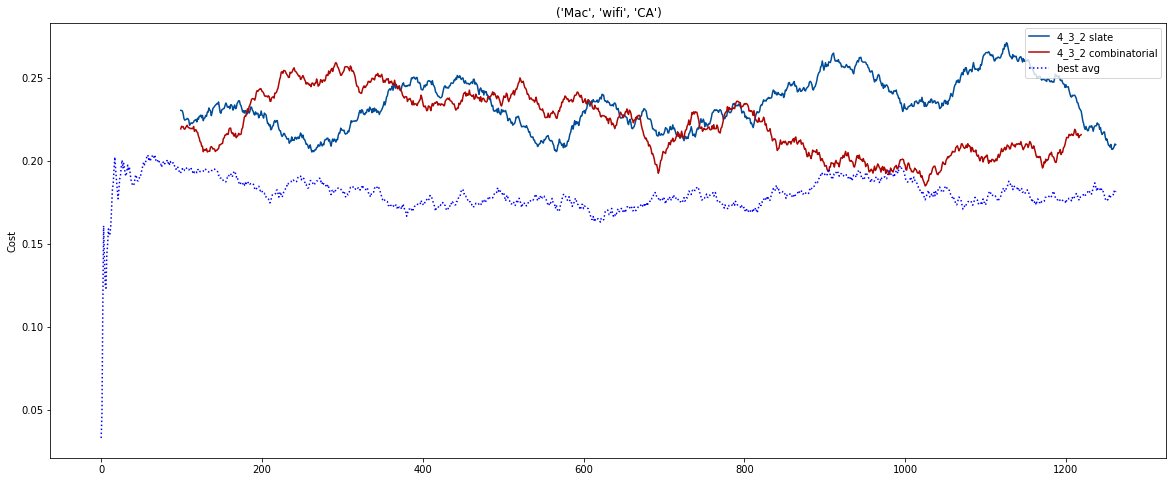

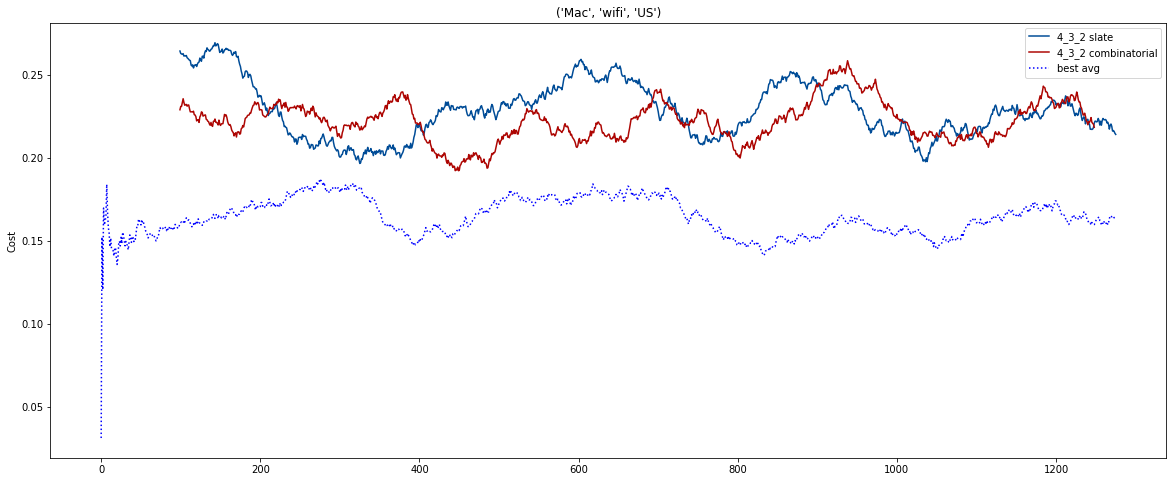

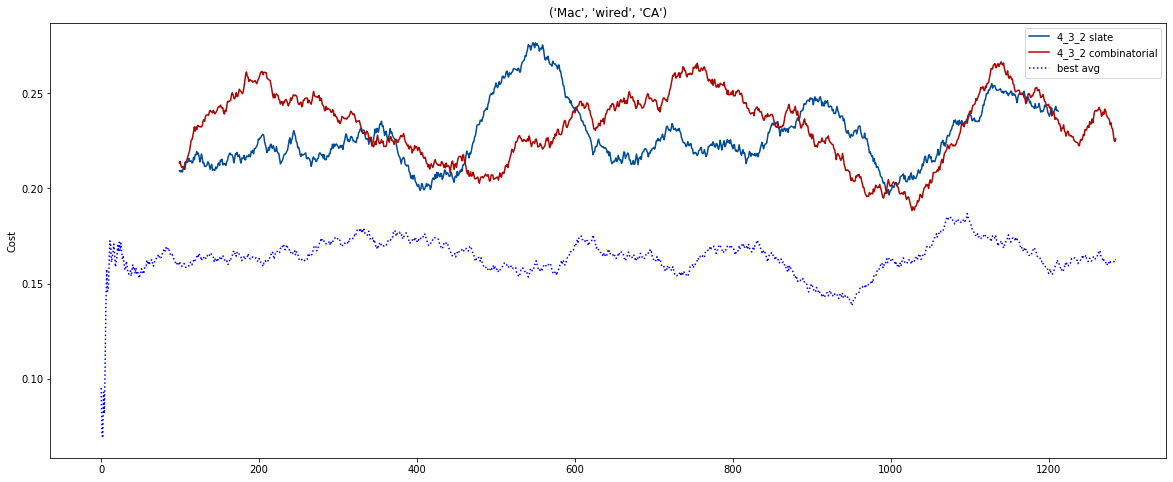

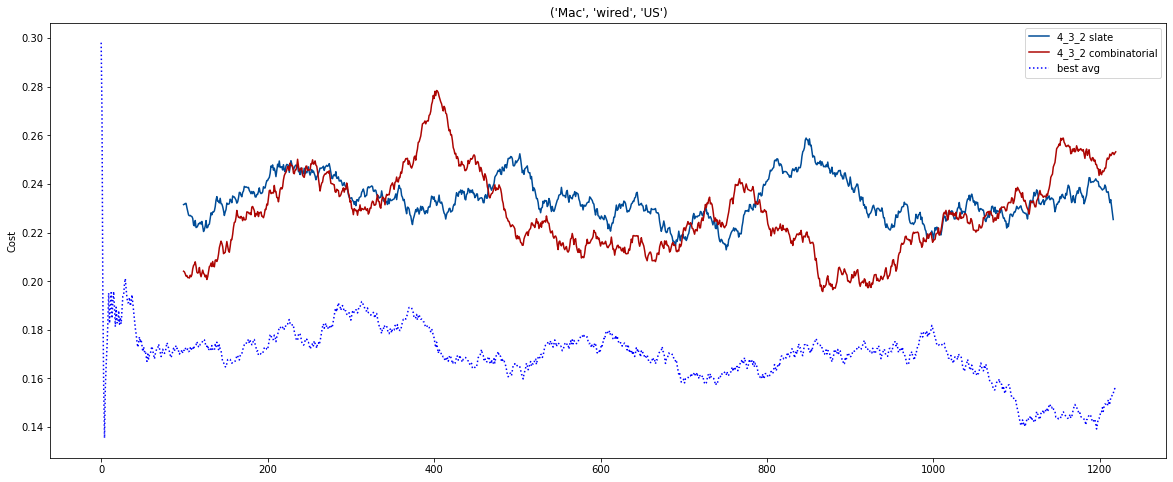

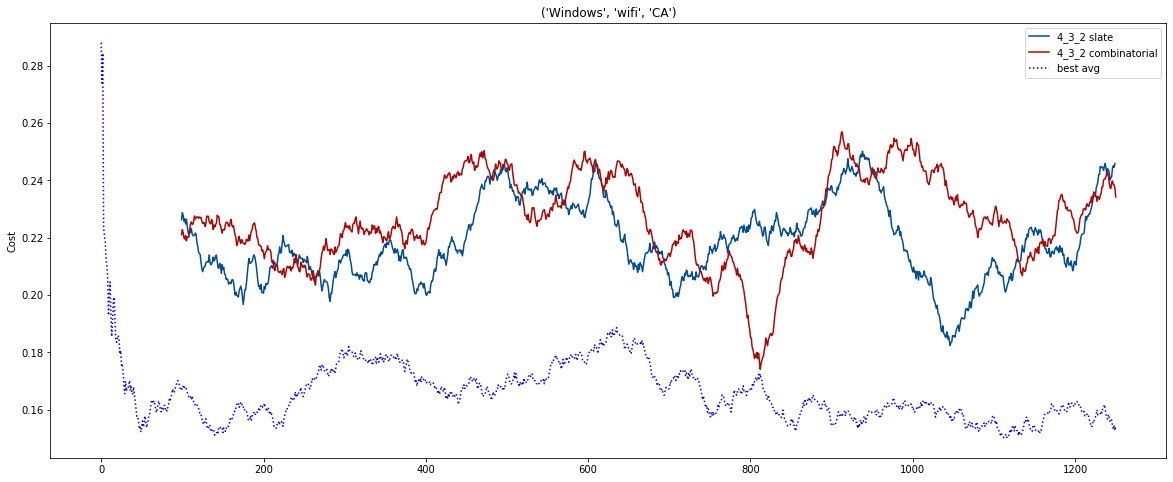

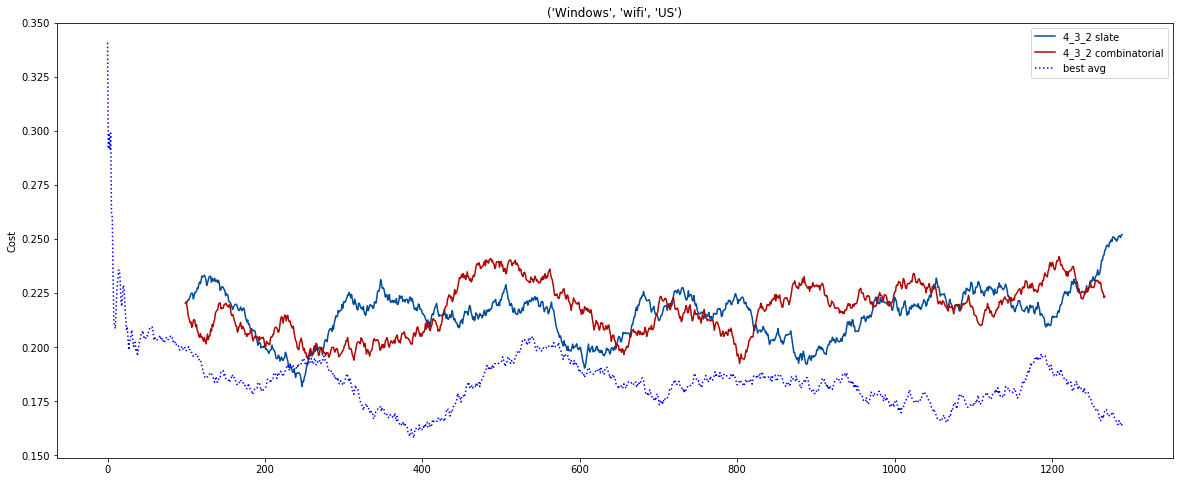

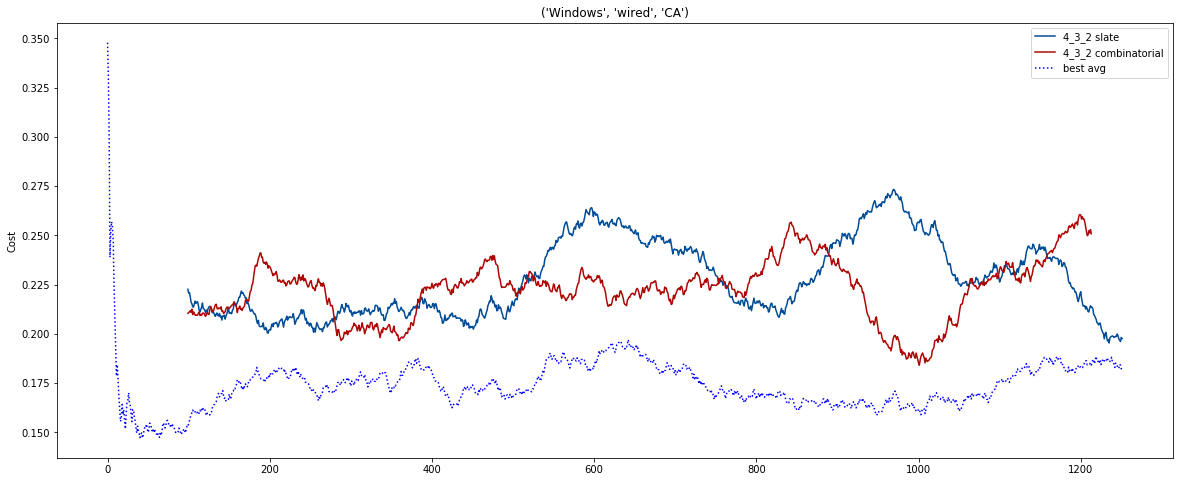

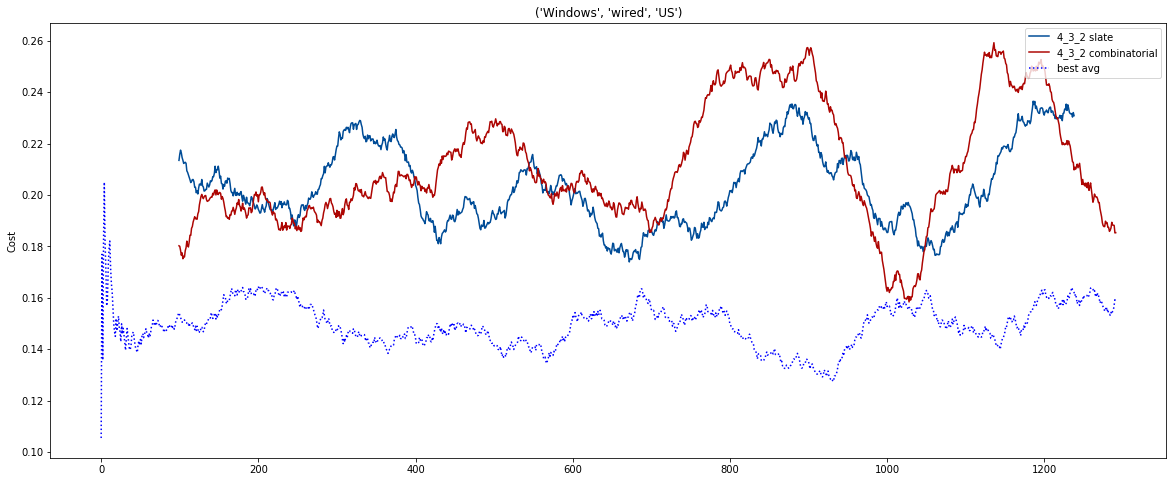

In [37]:
contexts = sorted(list(test_configs[next(iter(test_configs))]["outcomes"].keys()))

slate_colors = ['#004c97','#000097','#009797']
cb_colors = ['#ad0603', '#ad5b03', '#ad0355']

for context in contexts:
    plt.figure(figsize=(20, 8))
    number_of_samples = max(len(test_configs[name]["outcomes"][context]), len(test_configs[name]["cb_outcomes"][context]))
    for i, name in enumerate(test_configs):
        plt.plot(pd.Series(test_configs[name]["outcomes"][context]).rolling(100, min_periods=0).mean(), color=slate_colors[i], label="{} slate".format(name))
        plt.plot(pd.Series(test_configs[name]["cb_outcomes"][context]).rolling(100, min_periods=0).mean(), color=cb_colors[i], label="{} combinatorial".format(name))
    
    plt.ylabel("Cost")
    # Plot optimal policy by sampling optimal policy number_of_samples times
    optimal_policy_results = [optimal_policy_sample(context, min_actions[context]) for i in range(number_of_samples)]
    plt.plot(pd.Series(optimal_policy_results).rolling(120, min_periods=0).mean(), color='b', linestyle=':', label="best avg")

    plt.title("{}".format(context))
    plt.legend(loc="upper right")
    plt.show()
 


In [ ]:

contexts = sorted(list(test_configs[next(iter(test_configs))]["outcomes"].keys()))

slate_colors = ['#004c97','#000097','#009797']
cb_colors = ['#ad0603', '#ad5b03', '#ad0355']

for context in contexts:
    for i, name in enumerate(test_configs):
        data = test_configs[name]["x_outcomes"][context]
        actions = sorted(np.unique(data))
        x_action_counts = [sum(value == action for value in data) for action in actions]
        plt.bar(np.arange(len(actions)), x_action_counts)
        plt.xticks(np.arange(len(actions)), actions)
        plt.title("{} - X".format(context))
        plt.show()
        
        data = test_configs[name]["y_outcomes"][context]
        actions = sorted(np.unique(data))
        x_action_counts = [sum(value == action for value in data) for action in actions]
        plt.bar(np.arange(len(actions)), x_action_counts, color='g')
        plt.xticks(np.arange(len(actions)), actions)
        plt.title("{} - Y".format(context))
        plt.show()
        
        data = test_configs[name]["z_outcomes"][context]
        actions = sorted(np.unique(data))
        x_action_counts = [sum(value == action for value in data) for action in actions]
        plt.bar(np.arange(len(actions)), x_action_counts, color='y')
        plt.xticks(np.arange(len(actions)), actions)
        plt.title("{} - Z".format(context))
        plt.show()
               